In [156]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [157]:
# Loading the trained model and the scaler used to train the model
model=tf.keras.models.load_model('model_e100_filtered.h5')
scl=joblib.load('scaler_filtered.joblib')

In [158]:
# Read the csv
df=pd.read_csv('test_data.csv')
# df.drop(['PREPAYMENT_AMT'], axis = 1, inplace = True)
df.head()

,Loan Identifier,Monthly Reporting Period,Channel,Original Interest Rate,Current Interest Rate,Original UPB,Current Actual UPB,Original Loan Term,Origination Date,First Payment Date,...,Property Valuation Method,High Balance Loan Indicator,Unemployment_rate,Divorce_rate,Inflation_rate,EMI,UPB_diff,Interest_Component,Previous_UPB,Remaining MFM
0,100000822429,12013,1,3.25,3.25,166000.0,155011.71,180,32012,52012,...,4.0,0,7.4,3.3,1.6,1166.430156,1093.64,419.823381,156105.35,170
1,100000822429,22013,1,3.25,3.25,166000.0,153915.10,180,32012,52012,...,4.0,0,7.4,3.3,2.0,1166.430156,1096.61,416.853396,155011.71,169
2,100000822429,32013,1,3.25,3.25,166000.0,152815.52,180,32012,52012,...,4.0,0,7.4,3.3,1.5,1166.430156,1099.58,413.875367,153915.10,168
3,100000822429,42013,1,3.25,3.25,166000.0,151712.97,180,32012,52012,...,4.0,0,7.4,3.3,1.1,1166.430156,1102.55,410.889294,152815.52,167
4,100000822429,52013,1,3.25,3.25,166000.0,150607.43,180,32012,52012,...,4.0,0,7.4,3.3,1.4,1166.430156,1105.54,407.895123,151712.97,166


In [159]:
ic=[]
for i in range(len(df['Loan Identifier'])):
    ic.append(df.iloc[i,4]/1200*df.iloc[i,34])   
df['Interest_Component'] = ic

In [160]:
# Define a custom function to select the top 7 entries for each loan group
def select_top_entries(group):
    return group.head(7)
# Create a new DataFrame with the top 7 entries for each loan
top_entries = df.groupby('Loan Identifier').apply(select_top_entries)
# Reset the index of the resulting DataFrame
top_entries = top_entries.reset_index(drop=True)
df=top_entries

In [161]:
# Preprocessing df to create test pool
test_pool=df.drop_duplicates(subset='Loan Identifier', keep ='first')
emi = list(test_pool['EMI'])
test_pool.drop(['Loan Identifier','EMI','UPB_diff','Interest_Component','Remaining Months To Maturity'], axis=1, inplace = True)
test_pool['Modification Flag']=test_pool['Modification Flag'].fillna(2)
test_pool.head()

,Monthly Reporting Period,Channel,Original Interest Rate,Current Interest Rate,Original UPB,Current Actual UPB,Original Loan Term,Origination Date,First Payment Date,Original Loan to Value Ratio (LTV),...,Modification Flag,Zero Balance Code,Special Eligibility Program,Property Valuation Method,High Balance Loan Indicator,Unemployment_rate,Divorce_rate,Inflation_rate,Previous_UPB,Remaining MFM
0,12013,1,3.250,3.250,166000.0,155011.71,180,32012,52012,39,...,0.0,0.0,0,4.0,0,7.4,3.3,1.6,156105.35,170
7,112012,2,4.625,4.625,280000.0,277077.34,360,22012,42012,31,...,0.0,0.0,0,4.0,0,8.1,3.4,1.8,275996.89,351
14,62013,2,3.990,3.990,85000.0,80475.77,180,92012,112012,22,...,0.0,0.0,0,4.0,0,7.4,3.3,1.8,80906.76,171
21,82013,0,3.500,3.500,278000.0,273920.33,360,122012,22013,77,...,0.0,0.0,0,4.0,0,7.4,3.3,1.5,274416.05,352
28,122012,2,3.375,3.375,373000.0,360116.85,180,42012,62012,77,...,0.0,0.0,0,4.0,0,8.1,3.4,1.7,361743.12,172


In [162]:
# Splitting the test pool
X_test_pool=test_pool.drop(['Current Actual UPB'],axis=1)
y_test_pool=test_pool['Current Actual UPB']

In [163]:
# Unscaled test pool with all the columns
test_pool_unscaled = df.drop('Current Actual UPB', axis = 1)
test_pool_unscaled.drop_duplicates(subset='Loan Identifier', inplace=True)

In [164]:
# Helper functions for forecasting
# Function to update Monthly Reporting Period
def update_mrp(mrp):
    if((mrp//10000)==12):
        mrp = mrp - 110000 + 1
    else:
        mrp += 10000
    return mrp

# Unemployment Rates for the following years
Unemploy={"2000":4.0,
     "2001":4.7,
     "2002":5.8,
     "2003":6.0,
     "2004":5.5,
     "2005":5.1,
     "2006":4.6,
     "2007":4.6,
     "2008":5.8,
     "2009":9.3,
     "2010":9.6,
     "2011":8.9,
     "2012":8.1,
     "2013":7.4,
     "2014":6.2,
     "2015":5.3,
     "2016":4.9,
     "2017":4.4,
     "2018":3.9,
     "2019":3.7,
     "2020":8.1,
     "2021":5.3,
     "2022":3.6,
     "2023":3.4
     }

# Divorce Rates during the following years
divorce={"2000":4.0,
     "2001":4.0,
     "2002":3.9,
     "2003":3.8,
     "2004":3.7,
     "2005":3.6,
     "2006":3.7,
     "2007":3.6,
     "2008":3.5,
     "2009":3.5,
     "2010":3.6,
     "2011":3.6,
     "2012":3.4,
     "2013":3.3,
     "2014":3.2,
     "2015":3.1,
     "2016":3.0,
     "2017":2.9,
     "2018":2.9,
     "2019":2.7,
     "2020":2.3,
     "2021":2.5,
     "2022":2.3,
     "2023":2.3
     }

# Monthly Inflation Rates
inflation_data = {
    "12022": 7.5,
    "22022": 7.9,
    "32022": 8.5,
    "42022": 8.3,
    "52022": 8.6,
    "62022": 9.1,
    "72022": 8.5,
    "82022": 8.3,
    "92022": 8.2,
    "102022": 7.7,
    "112022": 7.1,
    "122022": 6.5,
    "12021": 1.4,
    "22021": 1.7,
    "32021": 2.6,
    "42021": 4.2,
    "52021": 5.0,
    "62021": 5.4,
    "72021": 5.4,
    "82021": 5.3,
    "92021": 5.4,
    "102021": 6.2,
    "112021": 6.8,
    "122021": 7.0,
    "12020": 2.5,
    "22020": 2.3,
    "32020": 1.5,
    "42020": 0.3,
    "52020": 0.1,
    "62020": 0.6,
    "72020": 1.0,
    "82020": 1.3,
    "92020": 1.4,
    "102020": 1.2,
    "112020": 1.2,
    "122020": 1.4,
    "12019": 1.6,
    "22019": 1.5,
    "32019": 1.9,
    "42019": 2.0,
    "52019": 1.8,
    "62019": 1.6,
    "72019": 1.8,
    "82019": 1.7,
    "92019": 1.7,
    "102019": 1.8,
    "112019": 2.1,
    "122019": 2.3,
    "12018": 2.1,
    "22018": 2.2,
    "32018": 2.4,
    "42018": 2.5,
    "52018": 2.8,
    "62018": 2.9,
    "72018": 2.9,
    "82018": 2.7,
    "92018": 2.3,
    "102018": 2.5,
    "112018": 2.2,
    "122018": 1.9,
    "12017": 2.5,
    "22017": 2.7,
    "32017": 2.4,
    "42017": 2.2,
    "52017": 1.9,
    "62017": 1.6,
    "72017": 1.7,
    "82017": 1.9,
    "92017": 2.2,
    "102017": 2.0,
    "112017": 2.2,
    "122017": 2.1,
    "12016": 1.4,
    "22016": 1.0,
    "32016": 0.9,
    "42016": 1.1,
    "52016": 1.0,
    "62016": 1.0,
    "72016": 0.8,
    "82016": 1.1,
    "92016": 1.5,
    "102016": 1.6,
    "112016": 1.7,
    "122016": 2.1,
    "12015": -0.1,
    "22015": 0.0,
    "32015": -0.1,
    "42015": -0.2,
    "52015": 0.0,
    "62015": 0.1,
    "72015": 0.2,
    "82015": 0.2,
    "92015": 0.0,
    "102015": 0.2,
    "112015": 0.5,
    "122015": 0.7,
    "12014": 1.6,
    "22014": 1.1,
    "32014": 1.5,
    "42014": 2.0,
    "52014": 2.1,
    "62014": 2.1,
    "72014": 2.0,
    "82014": 1.7,
    "92014": 1.7,
    "102014": 1.7,
    "112014": 1.3,
    "122014": 0.8,
    "12013": 1.6,
    "22013": 2.0,
    "32013": 1.5,
    "42013": 1.1,
    "52013": 1.4,
    "62013": 1.8,
    "72013": 2.0,
    "82013": 1.5,
    "92013": 1.2,
    "102013": 1.0,
    "112013": 1.2,
    "122013": 1.5,
    "12012": 2.9,
    "22012": 2.9,
    "32012": 2.7,
    "42012": 2.3,
    "52012": 1.7,
    "62012": 1.7,
    "72012": 1.4,
    "82012": 1.7,
    "92012": 2.0,
    "102012": 2.2,
    "112012": 1.8,
    "122012": 1.7,
    "12011": 1.6,
    "22011": 2.1,
    "32011": 2.7,
    "42011": 3.2,
    "52011": 3.6,
    "62011": 3.6,
    "72011": 3.6,
    "82011": 3.8,
    "92011": 3.9,
    "102011": 3.5,
    "112011": 3.4,
    "122011": 3.0,
    "12010": 2.6,
    "22010": 2.1,
    "32010": 2.3,
    "42010": 2.2,
    "52010": 2.0,
    "62010": 1.1,
    "72010": 1.2,
    "82010": 1.1,
    "92010": 1.1,
    "102010": 1.2,
    "112010": 1.1,
    "122010": 1.5,
    "12009": 0.0,
    "22009": 0.2,
    "32009": -0.4,
    "42009": -0.7,
    "52009": -1.3,
    "62009": -1.4,
    "72009": -2.1,
    "82009": -1.5,
    "92009": -1.3,
    "102009": -0.2,
    "112009": 1.8,
    "122009": 2.7,
    "12008": 4.3,
    "22008": 4.0,
    "32008": 4.0,
    "42008": 3.9,
    "52008": 4.2,
    "62008": 5.0,
    "72008": 5.6,
    "82008": 5.4,
    "92008": 4.9,
    "102008": 3.7,
    "112008": 1.1,
    "122008": 0.1,
    "12007": 2.1,
    "22007": 2.4,
    "32007": 2.8,
    "42007": 2.6,
    "52007": 2.7,
    "62007": 2.7,
    "72007": 2.4,
    "82007": 2.0,
    "92007": 2.8,
    "102007": 3.5,
    "112007": 4.3,
    "122007": 4.1,
    "12006": 4.0,
    "22006": 3.6,
    "32006": 3.4,
    "42006": 3.5,
    "52006": 4.2,
    "62006": 4.3,
    "72006": 4.1,
    "82006": 3.8,
    "92006": 2.1,
    "102006": 1.3,
    "112006": 2.0,
    "122006": 2.5,
    "12005": 3.0,
    "22005": 3.0,
    "32005": 3.1,
    "42005": 3.5,
    "52005": 2.8,
    "62005": 2.5,
    "72005": 3.2,
    "82005": 3.6,
    "92005": 4.7,
    "102005": 4.3,
    "112005": 3.5,
    "122005": 3.4,
    "12004": 1.9,
    "22004": 1.7,
    "32004": 1.7,
    "42004": 2.3,
    "52004": 3.1,
    "62004": 3.3,
    "72004": 3.0,
    "82004": 2.7,
    "92004": 2.5,
    "102004": 3.2,
    "112004": 3.5,
    "122004": 3.3,
    "12003": 2.6, 
    "22003": 3.0, 
    "32003": 3.0, 
    "42003": 2.2, 
    "52003": 2.1, 
    "62003": 2.1,
    "72003": 2.1, 
    "82003": 2.2, 
    "92003": 2.3, 
    "102003": 2.0, 
    "112003": 1.8, 
    "122003": 1.9,
    "12002": 1.1, 
    "22002": 1.1, 
    "32002": 1.5, 
    "42002": 1.6, 
    "52002": 1.2, 
    "62002": 1.1,
    "72002": 1.5, 
    "82002": 1.8, 
    "92002": 1.5, 
    "102002": 2.0, 
    "112002": 2.2, 
    "122002": 2.4,
    "12001": 3.7, 
    "22001": 3.5, 
    "32001": 2.9, 
    "42001": 3.3, 
    "52001": 3.6, 
    "62001": 3.2,
    "72001": 2.7, 
    "82001": 2.7, 
    "92001": 2.6, 
    "102001": 2.1, 
    "112001": 1.9, 
    "122001": 1.6,
    "12000": 2.7, 
    "22000": 3.2, 
    "32000": 3.8, 
    "42000": 3.1, 
    "52000": 3.2, 
    "62000": 3.7,
    "72000": 3.7, 
    "82000": 3.4, 
    "92000": 3.5, 
    "102000": 3.4, 
    "112000": 3.4, 
    "122000": 3.4,
    "12023": 6.4,
    "22023": 6.0,
    "32023": 5.0,
    "42023": 4.9
}

err=[70,140,220,440,550,650,800]

In [165]:
# Function to forecast subsequent monthly payments for a test pool
pred_pc , pred_cupb = np.zeros(7), np.zeros(7)
def dnn_forecast(x_test_pool): 
    for i in range(len(x_test_pool)):
        test_unscaled = x_test_pool[i:i+1] #single loan entry
        testing_x = scl.transform(test_unscaled)  #scaling the data for prediction

        #Converting 1D array to 2D array suitable for model prediction
        single_entry = np.expand_dims(testing_x[0], axis=0) 

        for j in range(7):   
            single_pred=model.predict(single_entry)     
            
            # Using the model to generate a prediction for the particular month
            pred_cupb[j] += single_pred[0][0]-err[j]
            # Updating parameters to forecast the value for the next month

            pred_pc[j] += float(df['EMI'][i*7+j])-((single_pred[0][0]-err[j])*(test_unscaled['Current Interest Rate'])/1200)

            test_unscaled['Previous_UPB']=single_pred[0][0]
            test_unscaled['Monthly Reporting Period']=update_mrp(int(test_unscaled['Monthly Reporting Period']))
            k=str(int(test_unscaled['Monthly Reporting Period']))
            k=k[::-1]
            r=k[:4]
            r=r[::-1]
            test_unscaled['Unemployment_rate']=Unemploy[r]
            test_unscaled['Divorce_rate']=divorce[r]
            test_unscaled['Inflation_rate']=inflation_data[str(int(test_unscaled['Monthly Reporting Period']))]
            test_unscaled['Remaining MFM']=int(test_unscaled['Remaining MFM'])-1

            test_scaled=(scl.transform(test_unscaled))[0]
            single_entry = np.expand_dims(test_scaled, axis=0)

In [166]:
dnn_forecast(X_test_pool)

1/1 [==============================] - 0s 19ms/step


In [167]:
act_pc , act_cupb, act_pupb, pred_pupb =  np.zeros(7), np.zeros(7), np.zeros(7), np.zeros(7)
for i in range(len(test_pool['Current Actual UPB'])):
    for j in range(7):
        act_pc[j] += df.iloc[i*7+j, 31] - df.iloc[i*7+j, 33]
        act_cupb[j] += df.iloc[i*7+j, 6]
        act_pupb[j] += df.iloc[i*7+j, 34]

for i in range(7):
    if i==0: pred_pupb[i] = act_pupb[i]
    else: pred_pupb[i] = pred_cupb[i-1]

In [168]:
act_smm, pred_smm, act_inflow, pred_inflow, act_cpr, pred_cpr = np.zeros(7), np.zeros(7), np.zeros(7), np.zeros(7), np.zeros(7), np.zeros(7)
for i in range(7):
    act_smm[i] = (act_pupb[i]- act_cupb[i]- act_pc[i])/act_cupb[i]
    pred_smm[i] = (pred_pupb[i]- pred_cupb[i]- pred_pc[i])/pred_cupb[i]
    act_inflow[i] = act_pupb[i]- act_cupb[i]- act_pc[i]+sum(emi)
    pred_inflow[i] = pred_pupb[i]- pred_cupb[i]- pred_pc[i]+sum(emi)
    act_cpr[i]= 1-pow(1-act_smm[i],12)
    pred_cpr[i]= 1-pow(1-pred_smm[i],12)

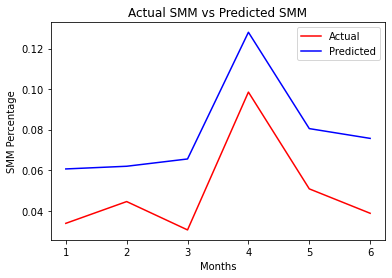

In [169]:
months = np.arange(1,7)

plt.plot(months, act_smm[:6]*100,color='red', label="Actual")
plt.plot(months, pred_smm[:6]*100,color='blue', label ="Predicted")

plt.xlabel('Months')
plt.ylabel('SMM Percentage')
plt.title('Actual SMM vs Predicted SMM')

# plt.yticks(np.arange(0,0.5,0.1))

plt.legend()

plt.show()

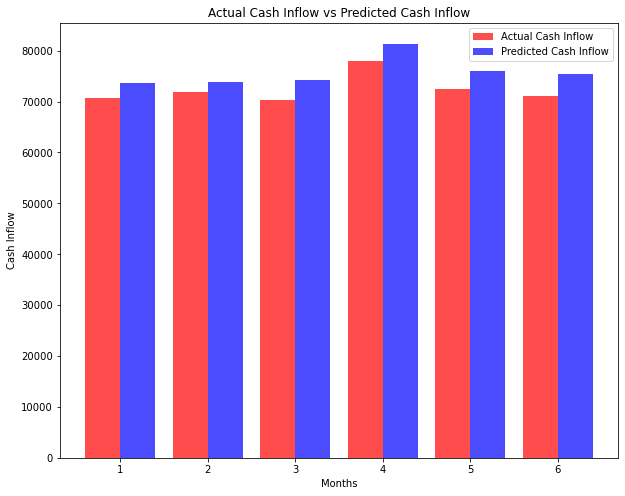

In [170]:
months = np.arange(1, 7)
bar_width = 0.4  # Width of each bar

plt.figure(figsize=(10,8))

plt.bar(months - bar_width/2, act_inflow[:6], label='Actual Cash Inflow', color='red', width=bar_width, alpha=0.7)
plt.bar(months + bar_width/2, pred_inflow[:6], label='Predicted Cash Inflow', color='blue', width=bar_width, alpha=0.7)

plt.xlabel('Months')
plt.ylabel('Cash Inflow')
plt.title('Actual Cash Inflow vs Predicted Cash Inflow')

plt.legend()
plt.show()

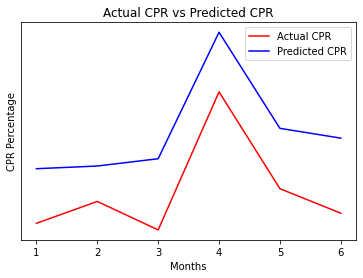

In [172]:
months = np.arange(1, 7) 

act_cpr=np.asarray(act_cpr)
pred_cpr=np.asarray(pred_cpr)

plt.plot(months, act_cpr[:6]*100, label='Actual CPR',color='red')
plt.plot(months, pred_cpr[:6]*100, label='Predicted CPR',color='blue')

plt.xlabel('Months')
plt.ylabel('CPR Percentage')
plt.title('Actual CPR vs Predicted CPR')

plt.yticks(np.arange(0,1,1))

plt.legend()

plt.show()

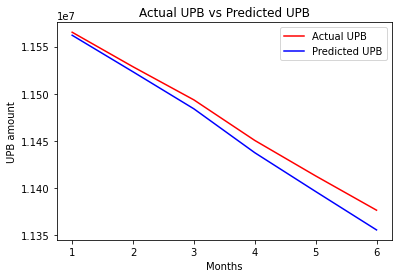

In [173]:
months = np.arange(1,7) 

plt.plot(months, act_cupb[:6], label='Actual UPB',color='red')
plt.plot(months, pred_cupb[:6], label='Predicted UPB',color='blue')

plt.xlabel('Months')
plt.ylabel('UPB amount')
plt.title('Actual UPB vs Predicted UPB')

# plt.yticks(np.arange(0, 10000000, 1000))

plt.legend()

plt.show()

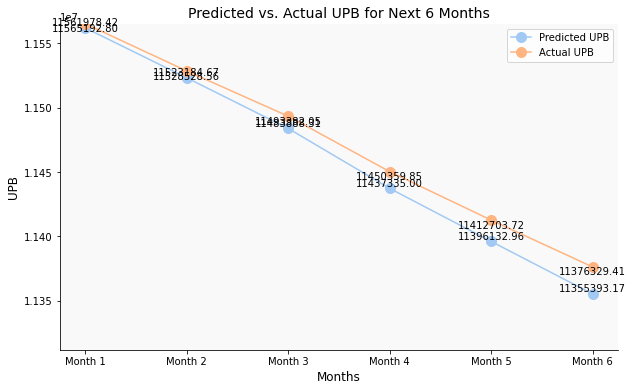

In [174]:
months = ['Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5', 'Month 6']

# Generating colors for the plot
colors = sns.color_palette('pastel')[0:2]

# Creating a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the predicted and actual UPB values
ax.plot(months, pred_cupb[:6], marker='o', markersize=10, linestyle='-', color=colors[0], label='Predicted UPB')
ax.plot(months, act_cupb[:6], marker='o', markersize=10, linestyle='-', color=colors[1], label='Actual UPB')

# Adding value annotations for predicted UPB
for i in range(len(months)):
    ax.text(i, pred_cupb[i], f'{pred_cupb[i]:.2f}', ha='center', va='bottom', fontsize=10)

# Adding value annotations for actual UPB
for i in range(len(months)):
    ax.text(i, act_cupb[i], f'{act_cupb[i]:.2f}', ha='center', va='top', fontsize=10)

# Customizing the plot aesthetics
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('UPB', fontsize=12)
ax.set_title('Predicted vs. Actual UPB for Next 6 Months', fontsize=14)
ax.legend(fontsize=10)

# Adjusting the y-axis limits
ax.set_ylim([min(np.min(pred_cupb), np.min(act_cupb)) - 100, max(np.max(pred_cupb), np.max(act_cupb)) + 100])

# Removing the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding a background color to the plot
ax.set_facecolor('#F9F9F9')

# Showing the plot
plt.show()